In [79]:
from torchvision.utils import draw_segmentation_masks
import math
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import time
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from collections import defaultdict
from itertools import chain
import torch.optim as optim
import os
import argparse
import sys
from collections import defaultdict
import math
from typing import cast, List, Optional, Dict, Tuple
from typing import Callable, Dict
from torch.utils.hooks import RemovableHandle
import torch
from torch import Tensor
from collections import OrderedDict, defaultdict, abc as container_abcs
import functools
import matplotlib.pyplot as plt
import numpy as np
#from .optimizer import Optimizer, _use_grad_for_differentiable
#from utils import progress_bar
required = object()

__all__ = ['Optimizer', 'register_optimizer_step_pre_hook', 'register_optimizer_step_post_hook']
_global_optimizer_pre_hooks: Dict[int, Callable] = OrderedDict()
_global_optimizer_post_hooks: Dict[int, Callable] = OrderedDict()

#Adam optimizer Base
#Optimizer Class Base, ADAM uses this
class Optimizer(object):
    r"""Base class for all optimizers.
    .. warning::
        Parameters need to be specified as collections that have a deterministic
        ordering that is consistent between runs. Examples of objects that don't
        satisfy those properties are sets and iterators over values of dictionaries.
    Args:
        params (iterable): an iterable of :class:`torch.Tensor` s or
            :class:`dict` s. Specifies what Tensors should be optimized.
        defaults: (dict): a dict containing default values of optimization
            options (used when a parameter group doesn't specify them).
    """

    def __init__(self, params, defaults):
        torch._C._log_api_usage_once("python.optimizer")
        self.defaults = defaults
        self._optimizer_step_pre_hooks: Dict[int, Callable] = OrderedDict()
        self._optimizer_step_post_hooks: Dict[int, Callable] = OrderedDict()

        self._patch_step_function()

        if isinstance(params, torch.Tensor):
            raise TypeError("params argument given to the optimizer should be "
                            "an iterable of Tensors or dicts, but got " +
                            torch.typename(params))

        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError("optimizer got an empty parameter list")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(param_group)

        # Allows _cuda_graph_capture_health_check to rig a poor man's TORCH_WARN_ONCE in python,
        # which I don't think exists
        # https://github.com/pytorch/pytorch/issues/72948
        self._warned_capturable_if_run_uncaptured = True


    def __getstate__(self):
        return {
            'defaults': self.defaults,
            'state': self.state,
            'param_groups': self.param_groups,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)
        if '_optimizer_step_pre_hooks' not in self.__dict__:
            self._optimizer_step_pre_hooks = OrderedDict()
        if '_optimizer_step_post_hooks' not in self.__dict__:
            self._optimizer_step_post_hooks = OrderedDict()
        self._patch_step_function()  # To support multiprocessing pickle/unpickle
        self.defaults.setdefault('differentiable', False)

    def __repr__(self):
        format_string = self.__class__.__name__ + ' ('
        for i, group in enumerate(self.param_groups):
            format_string += '\n'
            format_string += 'Parameter Group {0}\n'.format(i)
            for key in sorted(group.keys()):
                if key != 'params':
                    format_string += '    {0}: {1}\n'.format(key, group[key])
        format_string += ')'
        return format_string

    # Currently needed by Adam and AdamW
    def _cuda_graph_capture_health_check(self):
        if torch.has_cuda and torch.cuda.is_available():
            capturing = torch.cuda.is_current_stream_capturing()

            if capturing and not self.defaults['capturable']:
                raise RuntimeError("Attempting CUDA graph capture of step() for an instance of " +
                                   self.__class__.__name__ +
                                   " but this instance was constructed with capturable=False.")

            if (
                (not getattr(self, "_warned_capturable_if_run_uncaptured", False))
                and self.defaults["capturable"]
                and (not capturing)
            ):
                print("Warning: This instance was constructed with capturable=True, but step() " +
                      "is running without CUDA graph capture. If you never intend to graph-capture this " +
                      "instance, capturable=True can impair performance, and you should set capturable=False.")
                self._warned_capturable_if_run_uncaptured = True

    def _optimizer_step_code(self):
        """Entry point for `torch.profile.profiler`.
        When python tracing is enabled the profiler will hook into this
        function at the CPython level to inspect the optimizer's parameters and
        param groups. It is called it after `step()` since many optimizers
        lazily initialize state.
        This is a workaround due to lack of a proper step hook on the optimizer,
        and will be removed if it exists.
        """
        pass

    @staticmethod
    def profile_hook_step(func):

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            self, *_ = args
            profile_name = "Optimizer.step#{}.step".format(self.__class__.__name__)
            with torch.autograd.profiler.record_function(profile_name):
                # call optimizer step pre hooks
                for pre_hook in chain(_global_optimizer_pre_hooks.values(), self._optimizer_step_pre_hooks.values()):
                    result = pre_hook(self, args, kwargs)
                    if result is not None:
                        if isinstance(result, tuple) and len(result) == 2:
                            args, kwargs = result
                        else:
                            raise RuntimeError(f"{func} must return None or a tuple of (new_args, new_kwargs),"
                                               f"but got {result}.")

                out = func(*args, **kwargs)
                self._optimizer_step_code()

                # call optimizer step post hooks
                for post_hook in chain(self._optimizer_step_post_hooks.values(), _global_optimizer_post_hooks.values()):
                    post_hook(self, args, kwargs)

                return out

        return wrapper

    def _patch_step_function(self):
        self._zero_grad_profile_name = "Optimizer.zero_grad#{}.zero_grad".format(self.__class__.__name__)
        hooked = getattr(self.__class__.step, "hooked", None)
        if not hooked:
            self.__class__.step = self.profile_hook_step(self.__class__.step)
            self.__class__.step.hooked = True

    def register_step_pre_hook(self, hook: Callable[..., None]) -> RemovableHandle:
        r"""Register an optimizer step pre hook which will be called before
        optimizer step. It should have the following signature::
            hook(optimizer, args, kwargs) -> None or modified args and kwargs
        The ``optimizer`` argument is the optimizer instance being used. If
        args and kwargs are modified by the pre-hook, then the transformed
        values are returned as a tuple containing the new_args and new_kwargs.
        Args:
            hook (Callable): The user defined hook to be registered.
        Returns:
            :class:`torch.utils.hooks.RemoveableHandle`:
                a handle that can be used to remove the added hook by calling
                ``handle.remove()``
        """
        handle = hooks.RemovableHandle(self._optimizer_step_pre_hooks)
        self._optimizer_step_pre_hooks[handle.id] = hook
        return handle

    def register_step_post_hook(self, hook: Callable[..., None]) -> RemovableHandle:
        r"""Register an optimizer step post hook which will be called after optimizer step.
        It should have the following signature::
            hook(optimizer, args, kwargs) -> None
        The ``optimizer`` argument is the optimizer instance being used.
        Args:
            hook (Callable): The user defined hook to be registered.
        Returns:
            :class:`torch.utils.hooks.RemoveableHandle`:
                a handle that can be used to remove the added hook by calling
                ``handle.remove()``
        """
        handle = hooks.RemovableHandle(self._optimizer_step_post_hooks)
        self._optimizer_step_post_hooks[handle.id] = hook
        return handle

    def state_dict(self):
        r"""Returns the state of the optimizer as a :class:`dict`.
        It contains two entries:
        * state - a dict holding current optimization state. Its content
            differs between optimizer classes.
        * param_groups - a list containing all parameter groups where each
            parameter group is a dict
        """
        # Save order indices instead of Tensors
        param_mappings = {}
        start_index = 0

        def pack_group(group):
            nonlocal start_index
            packed = {k: v for k, v in group.items() if k != 'params'}
            param_mappings.update({id(p): i for i, p in enumerate(group['params'], start_index)
                                   if id(p) not in param_mappings})
            packed['params'] = [param_mappings[id(p)] for p in group['params']]
            start_index += len(packed['params'])
            return packed
        param_groups = [pack_group(g) for g in self.param_groups]
        # Remap state to use order indices as keys
        packed_state = {(param_mappings[id(k)] if isinstance(k, torch.Tensor) else k): v
                        for k, v in self.state.items()}
        return {
            'state': packed_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        r"""Loads the optimizer state.
        Args:
            state_dict (dict): optimizer state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        # deepcopy, to be consistent with module API
        state_dict = deepcopy(state_dict)
        # Validate the state_dict
        groups = self.param_groups
        saved_groups = state_dict['param_groups']

        if len(groups) != len(saved_groups):
            raise ValueError("loaded state dict has a different number of "
                             "parameter groups")
        param_lens = (len(g['params']) for g in groups)
        saved_lens = (len(g['params']) for g in saved_groups)
        if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
            raise ValueError("loaded state dict contains a parameter group "
                             "that doesn't match the size of optimizer's group")

        # Update the state
        id_map = {old_id: p for old_id, p in
                  zip(chain.from_iterable((g['params'] for g in saved_groups)),
                      chain.from_iterable((g['params'] for g in groups)))}

        def cast(param, value, key=None):
            r"""Make a deep copy of value, casting all tensors to device of param."""
            if isinstance(value, torch.Tensor):
                # Floating-point types are a bit special here. They are the only ones
                # that are assumed to always match the type of params.
                # Make sure state['step'] is not casted https://github.com/pytorch/pytorch/issues/74424
                if (key != "step"):
                    if param.is_floating_point():
                        value = value.to(param.dtype)
                    value = value.to(param.device)
                return value
            elif isinstance(value, dict):
                return {k: cast(param, v, key=k) for k, v in value.items()}
            elif isinstance(value, container_abcs.Iterable):
                return type(value)(cast(param, v) for v in value)
            else:
                return value

        # Copy state assigned to params (and cast tensors to appropriate types).
        # State that is not assigned to params is copied as is (needed for
        # backward compatibility).
        state = defaultdict(dict)
        for k, v in state_dict['state'].items():
            if k in id_map:
                param = id_map[k]
                state[param] = cast(param, v)
            else:
                state[k] = v

        # Update parameter groups, setting their 'params' value
        def update_group(group, new_group):
            new_group['params'] = group['params']
            return new_group
        param_groups = [
            update_group(g, ng) for g, ng in zip(groups, saved_groups)]
        self.__setstate__({'state': state, 'param_groups': param_groups})

    def zero_grad(self, set_to_none: bool = False):
        r"""Sets the gradients of all optimized :class:`torch.Tensor` s to zero.
        Args:
            set_to_none (bool): instead of setting to zero, set the grads to None.
                This will in general have lower memory footprint, and can modestly improve performance.
                However, it changes certain behaviors. For example:
                1. When the user tries to access a gradient and perform manual ops on it,
                a None attribute or a Tensor full of 0s will behave differently.
                2. If the user requests ``zero_grad(set_to_none=True)`` followed by a backward pass, ``.grad``\ s
                are guaranteed to be None for params that did not receive a gradient.
                3. ``torch.optim`` optimizers have a different behavior if the gradient is 0 or None
                (in one case it does the step with a gradient of 0 and in the other it skips
                the step altogether).
        """
        foreach = self.defaults.get('foreach', False)

        if not hasattr(self, "_zero_grad_profile_name"):
            self._patch_step_function()
        if foreach:
            per_device_and_dtype_grads = defaultdict(lambda: defaultdict(list))
        with torch.autograd.profiler.record_function(self._zero_grad_profile_name):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        if set_to_none:
                            p.grad = None
                        else:
                            if p.grad.grad_fn is not None:
                                p.grad.detach_()
                            else:
                                p.grad.requires_grad_(False)
                            if (not foreach or p.grad.is_sparse):
                                p.grad.zero_()
                            else:
                                per_device_and_dtype_grads[p.grad.device][p.grad.dtype].append(p.grad)
            if foreach:
                for _, per_dtype_grads in per_device_and_dtype_grads.items():
                    for grads in per_dtype_grads.values():
                        torch._foreach_zero_(grads)

    def step(self, closure):
        r"""Performs a single optimization step (parameter update).
        Args:
            closure (Callable): A closure that reevaluates the model and
                returns the loss. Optional for most optimizers.
        .. note::
            Unless otherwise specified, this function should not modify the
            ``.grad`` field of the parameters.
        """
        raise NotImplementedError

    def add_param_group(self, param_group):
        r"""Add a param group to the :class:`Optimizer` s `param_groups`.
        This can be useful when fine tuning a pre-trained network as frozen layers can be made
        trainable and added to the :class:`Optimizer` as training progresses.
        Args:
            param_group (dict): Specifies what Tensors should be optimized along with group
                specific optimization options.
        """
        assert isinstance(param_group, dict), "param group must be a dict"

        params = param_group['params']
        if isinstance(params, torch.Tensor):
            param_group['params'] = [params]
        elif isinstance(params, set):
            raise TypeError('optimizer parameters need to be organized in ordered collections, but '
                            'the ordering of tensors in sets will change between runs. Please use a list instead.')
        else:
            param_group['params'] = list(params)

        for param in param_group['params']:
            if not isinstance(param, torch.Tensor):
                raise TypeError("optimizer can only optimize Tensors, "
                                "but one of the params is " + torch.typename(param))
            if not self.defaults.get('differentiable', None) and not (param.is_leaf or param.retains_grad):
                raise ValueError("can't optimize a non-leaf Tensor")

        for name, default in self.defaults.items():
            if default is required and name not in param_group:
                raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                                 name)
            else:
                param_group.setdefault(name, default)

        params = param_group['params']
        if len(params) != len(set(params)):
            warnings.warn("optimizer contains a parameter group with duplicate parameters; "
                          "in future, this will cause an error; "
                          "see github.com/pytorch/pytorch/issues/40967 for more information", stacklevel=3)

        param_set = set()
        for group in self.param_groups:
            param_set.update(set(group['params']))

        if not param_set.isdisjoint(set(param_group['params'])):
            raise ValueError("some parameters appear in more than one parameter group")

        self.param_groups.append(param_group)
def _use_grad_for_differentiable(func):
    def _use_grad(self, *args, **kwargs):
        prev_grad = torch.is_grad_enabled()
        try:
            torch.set_grad_enabled(self.defaults['differentiable'])
            ret = func(self, *args, **kwargs)
        finally:
            torch.set_grad_enabled(prev_grad)
        return ret
    return _use_grad

class _MultiDeviceReplicator:
    main_tensor: Tensor
    _per_device_tensors: Dict[str, Tensor]

    def __init__(self, main_tensor: Tensor) -> None:
        self.main_tensor = main_tensor
        self._per_device_tensors = {str(main_tensor.device): main_tensor}

    def get(self, device: str):
        if device in self._per_device_tensors:
            return self._per_device_tensors[device]
        tensor = self.main_tensor.to(device=device, non_blocking=True, copy=True)
        self._per_device_tensors[device] = tensor
        return tensor

class Adam(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), epsilon=1e-7,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)


        for group in self.param_groups:

            for p in group['params']:
                grad = p.grad
                
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2,grad,grad)
                

                denom = exp_avg_sq.sqrt().add_(group['epsilon'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)


        return loss


class Higher_Moment_Adam(Optimizer):

    def __init__(self, params, num_moment = 2, lr=1e-2, betas=(0.9, 0.999, 0.999, 0.999, 0.999, 0.999), epsilon=1e-8,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay)
        super(Higher_Moment_Adam, self).__init__(params, defaults)
        self.num_moment = num_moment

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:

            # print("Parameter groups")
            # print(group['params'])
            # sys.exit()


            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient value
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()
                    #EMA of cubed gradient values (Divergent Algo)
                    state['exp_avg_cub'] = grad.new().resize_as_(grad).zero_()
                    #EMA of Quartic gradient values
                    state['exp_avg_quart'] = grad.new().resize_as_(grad).zero_()
                    #EMA for 5 (Divergent)
                    state['exp_avg_five'] = grad.new().resize_as_(grad).zero_()
                    #EMA Sixth moment
                    state['exp_avg_six'] = grad.new().resize_as_(grad).zero_()

                exp_avgs = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_cub'], state['exp_avg_quart'], state['exp_avg_five'], state['exp_avg_six']
                
                beta_array = group['betas'] #Beta1, Beta2, Beta3, Beta4, Beta6

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient

                #We always keep exponential average of first Moment
                exp_avgs[0].mul_(beta_array[0]).add_(1-beta_array[0], grad)


                #Second Moving Average dependent on num_moment
                exp_avgs[self.num_moment - 1].mul_(beta_array[self.num_moment-1]).addcmul_(1 - beta_array[self.num_moment - 1],grad, grad ** (self.num_moment-1))

                # exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # exp_avg_cub.mul_(beta3).add_(1 - beta3,grad ** 3)
                # exp_avg_quart.mul_(beta4).add_(1 - beta4, grad ** 4)
                # exp_avg_six.mul_(beta6).add_(1-beta6, grad ** 6)

                denom = (exp_avgs[self.num_moment - 1] ** (1./self.num_moment)).add_(group['epsilon'])
                # denom_sqrt = exp_avg_sq.sqrt().add_(group['epsilon'])
                # denom_cub = (exp_avg_cub ** 0.33).add_(group['epsilon'])
                # denom_quart = (exp_avg_quart ** 0.25).add_(group['epsilon'])
                # denom_six = (exp_avg_six ** (1./6)).add_(group['epsilon'])

                #Bias Correction for first estimate
                bias_correction1 = 1 - beta_array[0] ** state['step']

                #Bias Correction for num_moment
                bias_correction2 = 1 - beta_array[self.num_moment - 1] ** state['step']
                # bias_correction3 = 1 - beta3 ** state['step']
                # bias_correction4 = 1 - beta4 ** state['step']
                # bias_correction6 = 1 - beta6 ** state['step']


                step_size = group['lr'] * (bias_correction2 ** (1./self.num_moment)) / bias_correction1


                p.data.addcdiv_(-step_size, exp_avgs[0], denom)

        return loss

class Higher_Moment_Adam_Combination(Optimizer):

    def __init__(self, params,constants = [0.6,0.3,0.1], lr=1e-2, betas=(0.9, 0.999, 0.999, 0.999, 0.999, 0.999), epsilon=1e-8,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay)
        super(Higher_Moment_Adam_Combination, self).__init__(params, defaults)

        self.constants = constants


    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:

            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient value
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()
                    #EMA of cubed gradient values (Divergent Algo)
                    state['exp_avg_cub'] = grad.new().resize_as_(grad).zero_()
                    #EMA of Quartic gradient values
                    state['exp_avg_quart'] = grad.new().resize_as_(grad).zero_()
                    #EMA for 5 (Divergent)
                    state['exp_avg_five'] = grad.new().resize_as_(grad).zero_()
                    #EMA Sixth moment
                    state['exp_avg_six'] = grad.new().resize_as_(grad).zero_()

                exp_avgs = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_cub'], state['exp_avg_quart'], state['exp_avg_five'], state['exp_avg_six']
                
                beta_array = group['betas'] #Beta1, Beta2, Beta3, Beta4, Beta6

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient

                #We always keep exponential average of first Moment
                exp_avgs[0].mul_(beta_array[0]).add_(1-beta_array[0], grad)


                #Second Moving Average
                exp_avgs[1].mul_(beta_array[1]).addcmul_(1 - beta_array[1],grad, grad)

                #Fourth Moving Average
                exp_avgs[3].mul_(beta_array[3]).addcmul_(1 - beta_array[3],grad, grad ** 3)

                #Sixth Moving Average
                exp_avgs[5].mul_(beta_array[5]).addcmul_(1 - beta_array[5],grad, grad ** 5)


                #denom = (exp_avgs[self.num_moment - 1] ** (1./self.num_moment)).add_(group['epsilon'])
                denom_sqrt = exp_avgs[1].sqrt().add_(group['epsilon'])
                denom_quart = (exp_avgs[3] ** 0.25).add_(group['epsilon'])
                denom_six = (exp_avgs[5] ** (1./6)).add_(group['epsilon'])

                #Bias Correction for first estimate
                bias_correction1 = 1 - beta_array[0] ** state['step']

                #Bias Correction for num_moment
                bias_correction2 = 1 - beta_array[1] ** state['step']
                bias_correction4 = 1 - beta_array[2]  ** state['step']
                bias_correction6 = 1 - beta_array[3]  ** state['step']

                demon_sqrt = denom_sqrt * (bias_correction2 ** (1./2))
                denom_quart = denom_quart * (bias_correction4 ** (1./4))
                denom_six = denom_six * (bias_correction6 ** (1./6))

                denom = denom_sqrt * self.constants[0] + denom_quart * self.constants[1] + denom_six * self.constants[2]


                step_size = group['lr']# * (bias_correction2 ** (1./self.num_moment)) / bias_correction1


                p.data.addcdiv_(-step_size, exp_avgs[0], denom)

        return loss








In [ ]:
#Use similar methods on the L-Infinity Norm, of AdaMax 

class Adamax(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), eps=1e-8,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adamax, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    state['exp_inf'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_inf = state['exp_avg'], state['exp_inf']
                beta1, beta2 = group['betas']
                eps = group['eps']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Update biased first moment estimate.
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # Update the exponentially weighted infinity norm.
                norm_buf = torch.cat([
                    exp_inf.mul_(beta2).unsqueeze(0),
                    grad.abs().add_(eps).unsqueeze_(0)
                ], 0)
                state['exp_inf'] = exp_inf = (torch.max(norm_buf, 0)[0]).squeeze_(0)

                bias_correction = 1 - beta1 ** state['step']
                clr = group['lr'] / bias_correction

                p.data.addcdiv_(-clr, exp_avg, exp_inf)

        return loss


In [ ]:
#Build Resnet Model, Taken from following github 
#https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                    help='resume from checkpoint')

parser.add_argument('-f')
args = parser.parse_args()

device = 'cuda' #if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
==> Building model..


In [ ]:

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        adam_optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        adam_optimizer.step()


        #print(loss.item())

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% | Train Loss: %.3f'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, train_loss))
    end = time.time()
    total_time = start - end
    print("Training Loss: " + str(train_loss))
    print("Accuracy Train: " + str(100.*correct/total))
     
    accuracy_train = 100.*correct/total


    return train_loss, total_time, accuracy_train


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    start = time.time()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    end = time.time()
    total_time = start - end

    accuracy_test = 100.*correct/total

    print("Accuracy Test: " + str(accuracy_test))

    return test_loss, total_time, accuracy_test



loss_epoch_train = []
loss_epoch_test = []
train_times = []
test_times = []
accuracy_train = []
accuracy_test = []



net = ResNet18()

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
#adam_optimizer = Higher_Moment_Adam(net.parameters(),num_moment = 4, lr=args.lr)


adam_optimizer = Higher_Moment_Adam_Combination(net.parameters(), lr=args.lr)
for epoch in range(start_epoch, start_epoch+50):

    train_loss, train_time, train_acc = train(epoch)
    test_loss, test_time, test_acc = test(epoch)
    train_times.append(train_time)
    test_times.append(test_time)
    loss_epoch_train.append(train_loss)
    loss_epoch_test.append(test_loss)
    accuracy_train.append(train_acc)
    accuracy_test.append(test_acc)

Beta_pairs = [[0.9, 0.9], [0.9, 0.99], [0.9, 0.9999]] #Various experimentations with linear combinations


Text(0.5, 1.0, 'Accuracy Values Linear Combination')

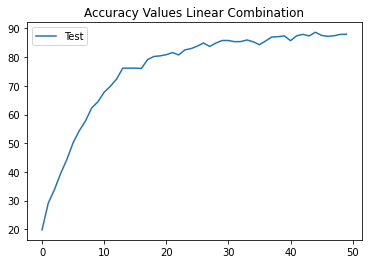

In [91]:
#loss_epoch_train

#plt.plot(x, loss_epoch_train, label = 'Train')
plt.plot(x, accuracy_test, label = 'Test')

plt.legend()
plt.title("Accuracy Values Linear Combination")

In [62]:
#@title Loss_test "Train Test Values Base + Fourth"
loss_test_base_adam = [178.88855457305908,164.2481153011322,143.52175092697144,139.37523436546326,124.71978342533112,106.49376368522644,93.98423230648041,87.11725968122482,
 94.99367958307266,
 69.01370817422867,
 73.70992550253868,
 63.60701060295105,
 57.481158673763275,
 69.08689758181572,
 56.91185972094536,
 53.943838715553284,
 51.81432193517685,
 46.24275428056717,
 58.22652170062065,
 52.093859642744064,
 44.91401121020317,
 46.017526760697365,
 44.332597851753235,
 43.834857016801834,
 51.18586912751198,
 41.578451707959175,
 49.055209308862686,
 44.8264592140913,
 51.342035099864006,
 44.525590285658836,
 46.74657629430294,
 42.21275094151497,
 44.01585873961449,
 36.1508816331625,
 37.409342892467976,
 38.04636097699404,
 43.66639156639576,
 38.024038061499596,
 41.02952742576599,
 42.26753577589989,
 39.96184095740318,
 40.99485543370247,
 43.7725714892149,
 40.90568472445011,
 42.35484831035137,
 41.36856722086668,
 45.63721489906311,
 45.40519092977047,
 41.778455182909966,
 41.87209476530552,
 43.983971893787384,
 41.16662015020847,
 38.70805002748966,
 43.837795957922935,
 47.39392165839672,
 44.488159745931625,
 40.54202161729336,
 42.88865298777819,
 45.807246431708336,
 44.751367807388306,
 40.70303028821945,
 46.4298624843359,
 44.605365328490734,
 43.38098421692848,
 45.66643013060093,
 46.04926314949989,
 49.905956238508224,
 45.20978211611509,
 47.73980408906937,
 41.83080519735813,
 40.05831020325422,
 44.9799108505249,
 47.25524081289768,
 42.136309273540974,
 44.917793539352715,
 43.60260144621134,
 55.214246690273285,
 45.0781322568655,
 58.66166231036186,
 48.73234611749649,
 44.4737983122468,
 49.48932720720768,
 44.71455103158951,
 45.932609245181084,
 51.60399487614632,
 45.36069846898317,
 45.174743451178074,
 47.22623609006405,
 46.65588567405939,
 45.27141531556845,
 49.084982842206955,
 49.99200475215912,
 51.10804598778486,
 45.8018844127655,
 49.71173983812332,
 44.8752763569355,
 52.08808310329914,
 42.717785231769085,
 49.5184885263443,
 47.82381744682789,
 44.16827488690615,
 49.702998384833336,
 56.196181789040565,
 49.617590233683586,
 47.51656625419855,
 50.548808578401804,
 52.646888077259064,
 48.71246849000454,
 55.32560175657272,
 49.30403649061918,
 50.94448297470808,
 52.49457588791847,
 48.26697151362896,
 50.96215735375881,
 45.77416727691889,
 47.16837852448225,
 46.34969278424978,
 68.90058863908052,
 49.91257646679878,
 51.8573549836874,
 47.534172505140305,
 50.684241980314255,
 50.90301205217838,
 45.43246676027775,
 49.031550869345665,
 45.59934317320585,
 52.46241453289986,
 49.39546665549278,
 51.29176318645477,
 50.03552649915218,
 51.1917120590806,
 51.10018413513899,
 57.94572140276432,
 50.5681863501668,
 50.62129710614681,
 51.84173783659935,
 53.91151598840952,
 52.7453171312809,
 52.04803989827633,
 57.71011482179165,
 47.87458912283182,
 50.014595456421375,
 50.84675532579422,
 52.01605397462845,
 51.83639082312584,
 47.09737265482545,
 51.3786511644721,
 47.51473930478096,
 57.48686946928501,
 49.73931169882417,
 51.522202387452126,
 49.2529269605875,
 52.4789919257164,
 49.843852177262306,
 50.75755852460861,
 44.443283565342426,
 54.25538479536772,
 47.06872037798166,
 53.57140472531319,
 51.06658525764942,
 43.22521302103996,
 54.2585614323616,
 58.20177008211613,
 49.93375405669212,
 54.49563254415989,
 54.53299854695797,
 52.38248107582331,
 46.73623154312372,
 56.42992161214352,
 53.99559722840786,
 51.68090100586414,
 48.70630398392677,
 51.84593351185322,
 54.02913746237755,
 51.60533732175827,
 51.678027763962746,
 51.39577154815197,
 56.512811943888664,
 50.89492929726839,
 49.81694108247757,
 53.277468394488096,
 64.15122370421886,
 49.1857011243701,
 52.51324054598808,
 53.57063888013363,
 52.35767260938883,
 53.92691057175398,
 48.92695586383343,
 54.30265399068594,
 49.56222564727068,
 53.67842149734497,
 52.4606940895319,
 58.350042924284935,
 49.21222591213882,
 58.46383385360241,
 52.70461079850793,
 51.17233430594206,
 52.05028270930052,
 63.04990355670452,
 54.457202173769474]


loss_train_base_adam = [881, 699, 641, 564, 504, 448, 402, 363, 323, 287, 264, 244, 228, 211, 198, 189, 176, 168, 161, 155, 146, 138, 
                        132, 127, 119, 117, 111, 107, 99, 98, 90, 87, 81, 81, 79, 74, 73, 70, 69, 64, 65, 62, 57, 59, 55, 53, 53, 50, 49, 48]

loss_train_fourth_moment = [927.4169118404388,
 750.1308370828629,
 650.1828107833862,
 561.403386592865,
 479.8413475751877,
 412.54544430971146,
 350.97448068857193,
 311.2108998298645,
 280.2383530139923,
 259.18204429745674,
 240.472284168005,
 223.6199105978012,
 212.69218680262566,
 202.57691404223442,
 188.8095402121544,
 182.16266217827797,
 172.8665352165699,
 166.70952631533146,
 160.59578274190426,
 152.68071094155312,
 148.84163308143616,
 144.74418088793755,
 136.6881795078516,
 129.97737462818623,
 127.54343339800835,
 124.48886343836784,
 120.22513529658318,
 115.14328534901142,
 110.7724487632513,
 110.17845764756203,
 104.8217182457447,
 100.71246568113565,
 97.71845369040966,
 95.91426191478968,
 93.58312889933586,
 88.14058370888233,
 85.39895900338888,
 83.68317657709122,
 79.90296434611082,
 79.70773231983185,
 75.21575416997075,
 73.47656562924385,
 72.2732394747436,
 66.7336655408144,
 65.30760604515672,
 65.00213773921132,
 61.34236164018512,
 60.20109133422375,
 56.9875048995018,
 56.7586821205914]
loss_test_fourth_moment =  [197.034245967865,
 175.1225597858429,
 179.9410502910614,
 140.35917270183563,
 142.643590092659,
 120.16054558753967,
 98.37131804227829,
 92.2648383975029,
 70.32772472500801,
 72.76514458656311,
 73.30880615115166,
 65.69602179527283,
 63.120308101177216,
 59.00047969818115,
 64.98241570591927,
 55.989049166440964,
 59.48752769827843,
 58.26536384224892,
 57.327521085739136,
 54.733152866363525,
 49.70021280646324,
 54.61900746822357,
 63.027589201927185,
 47.25513382256031,
 49.23023185133934,
 48.46295927464962,
 52.007421255111694,
 46.35703033208847,
 44.69533035159111,
 41.31400041282177,
 47.18763881921768,
 43.15188452601433,
 41.8188796043396,
 39.36996991932392,
 41.38656762242317,
 40.52386638522148,
 43.51588208973408,
 39.04230995476246,
 44.9901604950428,
 38.84670373797417,
 41.65626406669617,
 39.45741806924343,
 39.72451342642307,
 42.524006858468056,
 41.09580057859421,
 39.23822474479675,
 36.75931055098772,
 39.434265807271004,
 43.34569537639618,
 34.98411938548088]
accuracy_train_fourth = [16.468,
 23.148,
 36.616,
 47.066,
 55.614,
 62.382,
 68.574,
 72.276,
 75.318,
 77.006,
 78.834,
 80.448,
 81.366,
 82.282,
 83.422,
 84.228,
 84.784,
 85.472,
 86.06,
 86.654,
 86.99,
 87.366,
 88.198,
 88.746,
 88.998,
 89.274,
 89.592,
 90.14,
 90.36,
 90.52,
 90.968,
 91.194,
 91.494,
 91.636,
 91.752,
 92.352,
 92.5,
 92.77,
 93.118,
 92.994,
 93.522,
 93.628,
 93.6,
 94.154,
 94.208,
 94.272,
 94.676,
 94.824,
 95.098,
 95.006]
accuracy_test_fourth = [21.94,
 31.57,
 36.89,
 48.73,
 50.59,
 60.92,
 67.46,
 69.33,
 76.32,
 74.97,
 76.38,
 78.66,
 79.24,
 80.4,
 79.42,
 80.98,
 80.8,
 81.4,
 81.65,
 82.67,
 83.59,
 82.47,
 80.53,
 84.85,
 84.3,
 84.68,
 84.29,
 85.53,
 85.93,
 87.09,
 85.96,
 86.32,
 86.68,
 88.1,
 87.4,
 87.91,
 87.18,
 88.09,
 86.71,
 88.59,
 88.2,
 88.5,
 88.35,
 88.36,
 88.67,
 88.97,
 89.26,
 89.25,
 88.4,
 89.52]

In [67]:
#@title Loss_test "Train Test Values Sixth Moment"

test_loss_sixth = [186.53565871715546,
 172.23066186904907,
 147.40751683712006,
 136.66016137599945,
 123.4890147447586,
 104.99534958600998,
 104.72929435968399,
 99.84249275922775,
 103.63624769449234,
 78.8541214466095,
 81.44216683506966,
 72.80497369170189,
 63.0705443918705,
 65.84751951694489,
 64.99070584774017,
 54.737025529146194,
 54.34059289097786,
 55.04889592528343,
 53.8086833357811,
 49.11289966106415,
 53.46308568120003,
 48.98908108472824,
 51.89455737173557,
 45.35258774459362,
 46.47998803853989,
 42.541205793619156,
 46.74963368475437,
 43.80870772898197,
 42.65701800584793,
 40.70401640236378,
 43.91142039000988,
 48.442975997924805,
 45.55574832856655,
 41.82579496502876,
 42.13064716756344,
 39.897161051630974,
 37.920531898736954,
 38.46169684827328,
 39.54837283842394,
 45.5150113850832,
 48.99808478355408,
 37.8424528837204,
 48.450017750263214,
 40.251725390553474,
 40.24019983410835,
 45.55186256766319,
 46.49297232925892,
 35.489802211523056,
 39.19985434412956,
 43.53555729985237]

train_loss_sixth = [877, 675, 619, 567, 508, 449, 405, 363, 324, 293, 271, 251, 235, 221, 207, 200, 191, 182, 175, 169, 161, 157, 149, 145, 139, 136, 131, 126, 123, 121, 117, 111, 107, 105, 101, 101, 96, 92, 88, 87, 85, 80, 82, 76, 73, 71, 67, 65, 65]

train_accuracy_sixth = [21, 35, 41, 47, 52, 59, 63, 66, 71, 73, 76, 78, 79, 80.6, 81, 82, 83, 83, 84.7, 85.1, 85.8, 86.2, 86.7, 87.3, 87.76, 88.25, 88.5, 89, 89.1, 89.4, 89.7, 90.2, 90.5, 91, 90.9, 91.2, 91.9, 92.3, 92.4, 92.3, 92.9, 92.8, 93.3, 93.6, 93.8, 94, 94.2, 94.4]

test_accuracy_sixth = [31.4, 36.3, 47, 50.3, 56.3, 62.9, 63.8, 66.5, 64.2, 73.7, 73.5, 75, 79, 78, 77.8, 82, 82.2, 81.2, 82, 83.8, 81.9, 83.3, 83.84, 85, 84.9, 85.6, 84.5, 85.3, 86.2, 87, 86, 85.4, 86.2, 87.2, 87, 87.6, 88, 87.8, 86, 86.5, 88.5, 86.6, 88.2, 88.3, 87.2, 86.9, 89.7, 89.2, 88.4]


In [64]:
#@title "Train test ADAMAX"

train_loss_adamax = [961.4833263158798,
 721.5626999139786,
 638.3771440982819,
 559.7407019138336,
 484.47208619117737,
 427.20785969495773,
 383.9229093194008,
 347.0448525547981,
 318.0837107896805,
 286.2909709215164,
 258.54165637493134,
 235.62502178549767,
 216.72219324111938,
 201.05847281217575,
 183.13527783751488,
 170.37938061356544,
 159.26789785921574,
 147.19711662828922,
 138.92985007166862,
 129.9578741788864,
 122.91766294836998,
 115.44108083844185,
 109.69218334555626,
 102.93561989068985,
 97.11564480513334,
 90.75371991097927,
 88.636883251369,
 84.37695590406656,
 78.57145832479,
 74.92267142608762,
 70.98505830019712,
 69.36524529755116,
 65.18170199915767,
 62.8229553848505,
 59.13019456341863,
 56.02439748868346,
 54.07115286029875,
 50.735319916158915,
 48.5574570633471,
 49.10685541853309,
 45.16130422800779,
 44.15745733678341,
 42.31737398542464,
 41.00172444432974,
 40.20487502031028,
 37.641895269975066,
 35.94961941614747,
 36.23242471367121,
 34.448829958215356,
 32.50425815116614]

test_loss_adamax = [199.22926795482635,
 171.69947409629822,
 152.16405308246613,
 146.89171361923218,
 120.42671191692352,
 108.83349639177322,
 98.21870893239975,
 87.2787504196167,
 81.18961673974991,
 96.83516252040863,
 78.6710861325264,
 63.09321188926697,
 66.32221373915672,
 57.715924471616745,
 53.10077863931656,
 60.897301375865936,
 51.09147039055824,
 53.39453661441803,
 40.57170952856541,
 40.7362444549799,
 45.41699945926666,
 43.03095477819443,
 37.04428853094578,
 40.282377898693085,
 37.604069486260414,
 36.02277199923992,
 39.51322677731514,
 38.63366770744324,
 37.83583492040634,
 36.47644639015198,
 40.749075427651405,
 34.94757369160652,
 35.5237203091383,
 31.924066111445427,
 38.53678843379021,
 37.32438103854656,
 35.26712377369404,
 36.71824507415295,
 38.32617897540331,
 33.35686667263508,
 36.527569465339184,
 41.07395377755165,
 41.13782234489918,
 39.87831622362137,
 36.7998091429472,
 36.411990620195866,
 40.203480526804924,
 40.29737688601017,
 39.32381780445576,
 40.55578710138798]
train_accuracy_adamax = [14.64,
 27.136,
 36.872,
 46.45,
 54.478,
 61.158,
 65.02,
 68.684,
 71.248,
 74.48,
 77.006,
 79.186,
 81.202,
 82.172,
 83.83,
 85.076,
 86.058,
 87.208,
 87.578,
 88.58,
 89.046,
 89.846,
 90.234,
 90.828,
 91.45,
 91.968,
 92.198,
 92.386,
 93.008,
 93.176,
 93.682,
 93.81,
 94.204,
 94.426,
 94.64,
 94.958,
 95.1,
 95.478,
 95.692,
 95.572,
 96.024,
 96.022,
 96.332,
 96.456,
 96.45,
 96.642,
 96.766,
 96.768,
 96.844,
 97.042]
test_accuracy_adamax = [21.05,
 33.59,
 43.62,
 48.72,
 57.52,
 61.75,
 65.64,
 68.71,
 71.67,
 68.56,
 73.75,
 78.66,
 78.24,
 80.38,
 82.22,
 80.16,
 83.35,
 83.47,
 86.53,
 86.17,
 85.26,
 86.69,
 87.85,
 87.7,
 87.88,
 88.72,
 87.68,
 88.5,
 88.69,
 88.37,
 88.15,
 89.74,
 89.47,
 90.48,
 89.07,
 89.74,
 89.9,
 90.22,
 89.55,
 90.74,
 90.69,
 89.46,
 89.68,
 90.54,
 90.51,
 91.14,
 90.19,
 90.81,
 90.56,
 90.79]

adamax_time = -2.9



In [65]:
#@title Accuracy values Base

base_train_accuracy = [27.32,
 39.334,
 48.184,
 56.516,
 61.912,
 65.424,
 68.298,
 71.432,
 74.222,
 76.858,
 78.884,
 80.352,
 81.658,
 82.79,
 83.802,
 84.576,
 85.114,
 86.004,
 86.68,
 87.158,
 87.712,
 88.596,
 88.772,
 89.322,
 89.76,
 90.114,
 90.34,
 90.698,
 90.93,
 91.608,
 91.62,
 92.104,
 92.296,
 92.408,
 92.728,
 92.932,
 93.432,
 93.484,
 93.736,
 93.868,
 94.044,
 94.272,
 94.356,
 94.512,
 94.594,
 94.794,
 95.002,
 95.172,
 95.088,
 95.388]

base_test_accuracy = [36.0,
 43.75,
 53.87,
 59.07,
 62.69,
 67.18,
 70.2,
 69.26,
 74.56,
 77.64,
 75.16,
 77.4,
 79.53,
 80.63,
 80.97,
 84.58,
 82.7,
 83.13,
 83.15,
 84.18,
 84.26,
 85.05,
 85.91,
 83.74,
 85.37,
 85.27,
 86.24,
 85.55,
 86.37,
 85.98,
 87.53,
 87.3,
 86.55,
 86.67,
 87.09,
 87.54,
 88.07,
 88.31,
 87.52,
 88.53,
 88.07,
 88.5,
 88.03,
 88.47,
 88.69,
 88.97,
 89.04,
 88.91,
 89.22,
 89.46]

In [ ]:
#@title Linear Combination Moments

# betapair1_train_loss = 
# betapair1_test_loss = 

# betapair1_train_accuracy = 
# betapair1_test_accuracy =

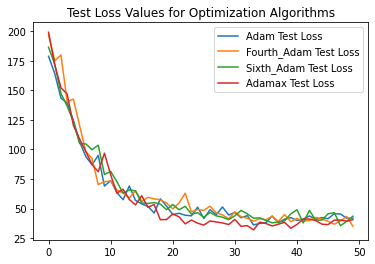

In [ ]:
#Plot Errors, LOSS TEST

#LOSS TRAIN ERRORS: loss_train_base_adam, loss_train_fourth_moment, train_loss_adamax



#LOSS TEST ERRORS: loss_test_base_adam, loss_test_fourth_moment, test_loss_adamax, 

#ACCURACY TRAIN ERRORS: accuracy_train_fourth, base_train_accuracy, train_accuracy_adamax

#ACCURACY TEST ERRORS: accuracy_test_fourth, base_test_accurarcy, test_accuracy_adamax

x = np.arange(50)

plt.plot(x, loss_test_base_adam[:50], label = 'Adam Test Loss')
plt.plot(x, loss_test_fourth_moment[:50], label = 'Fourth_Adam Test Loss')
plt.plot(x, test_loss_sixth[:50], label = 'Sixth_Adam Test Loss')
plt.plot(x, test_loss_adamax[:50], label = 'Adamax Test Loss')

plt.title('Test Loss Values for Optimization Algorithms')
plt.legend()


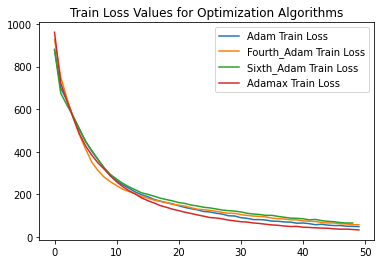

In [74]:
#PLOT GRAPHS FOR TRAIN LOSS

plt.plot(x, loss_train_base_adam[:50], label = 'Adam Train Loss')
plt.plot(x, loss_train_fourth_moment[:50], label = 'Fourth_Adam Train Loss')
plt.plot(x[:49], train_loss_sixth[:50], label = 'Sixth_Adam Train Loss')
plt.plot(x, train_loss_adamax[:50], label = 'Adamax Train Loss')

plt.title('Train Loss Values for Optimization Algorithms')
plt.legend()

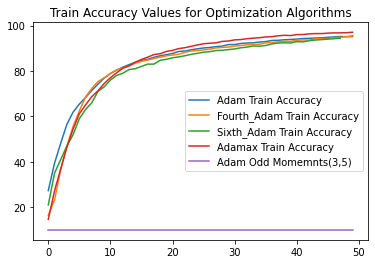

In [76]:
#Accuracy Train PLOTS

Odd_accuracy = np.full(50, 10)

plt.plot(x, base_train_accuracy[:50], label = 'Adam Train Accuracy')
plt.plot(x, accuracy_train_fourth[:50], label = 'Fourth_Adam Train Accuracy')
plt.plot(x[:48], train_accuracy_sixth[:50], label = 'Sixth_Adam Train Accuracy')
plt.plot(x, train_accuracy_adamax[:50], label = 'Adamax Train Accuracy')
plt.plot(x, Odd_accuracy, label = 'Adam Odd Momemnts(3,5) ')

plt.title('Train Accuracy Values for Optimization Algorithms')
plt.legend()

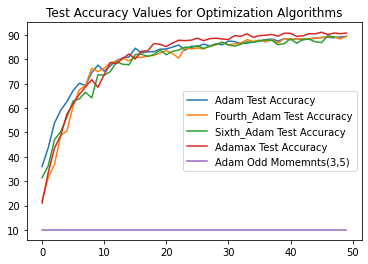

In [82]:
#Accuracy Test Plots

Odd_accuracy = np.full(50, 10)

plt.plot(x, base_test_accuracy[:50], label = 'Adam Test Accuracy')
plt.plot(x, accuracy_test_fourth[:50], label = 'Fourth_Adam Test Accuracy')
plt.plot(x[:48], test_accuracy_sixth[:48], label = 'Sixth_Adam Test Accuracy')
plt.plot(x, test_accuracy_adamax[:50], label = 'Adamax Test Accuracy')
plt.plot(x, Odd_accuracy, label = 'Adam Odd Momemnts(3,5) ')



plt.title('Test Accuracy Values for Optimization Algorithms')
plt.legend()